Desenvolvido por Filipe Junio.
github.com/FelpsMG

## Análise dos dados dos últimos 10 anos da premier league 

![Alt text](../../G:/trab_luiz/Premier_League-Logo.wine.png)


Data Science na Premier League

A ideia deste trabalho é apresentar os dados de estatística da Premier League, a primeira divisão do campeonato inglês de futebol. Com esse notebook, será possível levantar predições para o número de escanteios a favor do time mandante, usando um banco de dados com estatísticas recentes dos jogos e dos times da Premier League.

A escolha do número de escanteios, se dá pela alta procura desse dado nas casas de apostas. O fato do futebol ser um esporte muito imprevisível, foi um fator crucial na escolha dessa feature, já que fica difícil a predição de resultados exatos.

Para a análise desses dados, foram usados como base, os artigos: "An Econometric Analysis of the Relationship Between Corner Kick Numbers and Football Outcomes"; "Forecasting number of corner kicks taken in association football using overdispersed distribution" e "Prediction of Football Match Score and Decision Making Process".

Como referência de códigos, foram usados alguns exemplos já implementados na internet em sites como GitHub e Kaggle. Foram eles: "Soccer Tracking Data; "European Soccer Database e "Football predition model. A escolha destes artigos e códigos se deu pela semelhança da proposta desse notebook, já que o objetivo proposto é poder predizer de uma forma simples e objetiva estatísticas do futebol, mais precisamente o número de escanteios para o time mandante, em casas de apostas, já que é uma estatística com um certo grau de previsibilidade.

O banco de dados usado como referência, foi tirado do site Football-data; esse banco de dados foi escolhido por ter informações relevantes e recentes, já que o futebol é um esporte onde o momento dos times é extremamente crucial para predizer alguns resultados e estatísticas.

In [30]:
%%capture --no-display
!pip install matplotlib scikit-learn 

In [18]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
from datetime import datetime
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


## Tratamento dos dados

Chave para os dados:

Div = Divisão da Liga

Data = Data da correspondência (dd/mm/aa)

HomeTeam = Time da casa

AwayTeam = Time visitante

FTHG e HG = Gols do time da casa

FTAG e AG = Gols do time visitante ao final da partida

FTR e Res = Resultado final (H=Vitória em casa, D=Empate, A=Vitória fora de casa)

HTHG = Gols do time da casa ao intervalo

HTAG = Gols do time visitante ao intervalo

HTR = Resultado ao intervalo (H=Vitória em casa, D=Empate, A=Vitória fora de casa)

Estatísticas da partida (quando disponível)

Presença = Presença da Multidão

Árbitro = Árbitro da partida

HS = Chutes a gol time da casa

AS = Chutes a gol time visitante

HST = Chute a gol com direção ao alvo, time da casa

AST = Chute a gol com direção ao alvo, time da visitante

HHW = Bolas na trave time da casa

AHW = Bolas na trave time visitante

HC = Escanteios do time da casa

AC = Escanteios do time Visitante

HF = Faltas cometidas pelo time da casa

AF = Faltas cometidas pela equipe visitante

HFKC = Faltas concedidas pela equipe da casa

AFKC = Faltas concedidas pela equipe visitante

HO = Laterais do time da casa

AO = Laterais da Equipe Visitante

HY = Cartões Amarelos do Time da Casa

AY = Cartões Amarelos do Time Visitante

HR = Cartões Vermelhos do Time da Casa

AR = Cartões Vermelhos do Time Visitante

In [19]:
data_path = Path('./dados/')
list_data = (pd.read_csv(f, sep=',', decimal='.', low_memory=False) for f in data_path.glob('*.csv'))
data = pd.concat(list_data, ignore_index=True)
col_select = ['Div','Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','Referee','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']
data = data[col_select]
# print(data)
data['season_year'] = data['Date']

for index, dt in enumerate(data['Date']):
    
    data['Date'][index] = pd.to_datetime(dt,format='%d/%m/%Y', dayfirst=True).date()
    match_year = int(data['Date'][index].year)
    
    if data['Date'][index] <= pd.to_datetime(f'01/08/{match_year}',format='%d/%m/%Y').date():
        data['season_year'][index] = f'{match_year-1}/{match_year}'
    # elif  data['Date'][index] <= pd.to_datetime(f'30/05/{match_year}',format='%d/%m/%Y').date():
    else:
        data['season_year'][index] = f'{match_year}/{match_year+1}'

    

In [20]:
from IPython.display import display, HTML
data = data.sort_values(by = 'Date')

print ("DATA FRAME DADOS DE PARTIDAS")
display(HTML(data[0:100].to_html(justify='start', notebook = True)))

DATA FRAME DADOS DE PARTIDAS


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,season_year
764,E0,2011-08-13,QPR,Bolton,0,4,A,0,1,A,M Atkinson,13,13,7,7,9,16,3,2,1,2,1,0,2011/2012
761,E0,2011-08-13,Fulham,Aston Villa,0,0,D,0,0,D,L Mason,13,7,9,1,10,18,2,3,2,4,0,0,2011/2012
762,E0,2011-08-13,Liverpool,Sunderland,1,1,D,1,0,H,P Dowd,11,15,4,6,17,12,6,3,4,4,0,0,2011/2012
763,E0,2011-08-13,Newcastle,Arsenal,0,0,D,0,0,D,P Walton,6,9,1,4,9,11,2,5,3,5,0,1,2011/2012
765,E0,2011-08-13,Wigan,Norwich,1,1,D,1,1,D,S Attwell,18,13,11,3,11,8,7,3,2,2,0,0,2011/2012
760,E0,2011-08-13,Blackburn,Wolves,1,2,A,1,1,D,K Friend,16,13,8,4,14,10,12,6,4,2,0,0,2011/2012
766,E0,2011-08-14,Stoke,Chelsea,0,0,D,0,0,D,M Halsey,6,20,3,11,12,12,4,6,2,2,0,0,2011/2012
767,E0,2011-08-14,West Brom,Man United,1,2,A,1,1,D,M Jones,14,11,8,5,16,9,6,5,3,2,0,0,2011/2012
768,E0,2011-08-15,Man City,Swansea,4,0,H,0,0,D,M Dean,26,8,19,5,9,2,7,4,0,0,0,0,2011/2012
774,E0,2011-08-20,Swansea,Wigan,0,0,D,0,0,D,P Dowd,12,10,6,4,8,18,7,7,0,3,0,0,2011/2012


## Visualização dos dados 

In [21]:
# Agrupamento dos dados para melhor visualização global

def vitorias(resultados, home_or_away):
    # print(resultados)
    n_vit = 0
    for resultado in resultados:
        if resultado == home_or_away:
            n_vit = n_vit+1
    return n_vit

df2 = pd.DataFrame(columns=['Time', 'gols_marcados','gols_marcados_em_casa','gols_marcados_fora_casa', 'vitorias','vitorias_fora',
                    'vitorias_casa','escanteios', 'escanteios_em_casa', 'escanteios_fora_casa', 'chutes_a_gol', 'chutes_a_gol_fora_casa', 'chutes_a_gol_em_casa', 'temporada'])
teams = []
for team in data['HomeTeam'].unique():
    for season in data['season_year'].unique():
        aux_data = data[ data['season_year'] == season ]
        team_season_data = aux_data[aux_data['HomeTeam'] == team]
        aux_season_data = aux_data[ aux_data['AwayTeam'] == team]
        team_season_data = pd.concat([team_season_data,aux_season_data ], ignore_index=True)

        time = team

        gols_marcados_em_casa = sum(team_season_data['FTHG'][team_season_data['HomeTeam'] == team])
        gols_marcados_fora_casa = sum(team_season_data['FTAG'][team_season_data['AwayTeam'] == team])
        gols_marcados = gols_marcados_em_casa + gols_marcados_fora_casa

        escanteios_fora_casa = sum(team_season_data['HC'][team_season_data['HomeTeam'] == team])
        escanteios_em_casa = sum(team_season_data['AC'][team_season_data['AwayTeam'] == team])
        escanteios = escanteios_fora_casa + escanteios_em_casa
        
        chutes_fora_casa = sum(team_season_data['HS'][team_season_data['HomeTeam'] == team])
        chutes_em_casa = sum(team_season_data['AS'][team_season_data['AwayTeam'] == team])
        chutes_a_gol = chutes_fora_casa + chutes_em_casa

        vitorias_em_casa = vitorias(team_season_data['FTR'][team_season_data['HomeTeam'] == team],'H')
        vitorias_fora_casa = vitorias(team_season_data['FTR'][team_season_data['HomeTeam'] == team],'A')
        vitorias_totais = vitorias_em_casa + vitorias_fora_casa
        temporada = season
        
        row = {'Time':time, 'gols_marcados':gols_marcados,'gols_marcados_em_casa':gols_marcados_em_casa,'gols_marcados_fora_casa':gols_marcados_fora_casa,
                    'vitorias':vitorias_totais,'vitorias_fora':vitorias_fora_casa, 'vitorias_casa':vitorias_em_casa,'escanteios':escanteios, 'escanteios_em_casa':escanteios_em_casa,
                    'escanteios_fora_casa':escanteios_fora_casa, 'chutes_a_gol':chutes_a_gol, 'chutes_a_gol_fora_casa':chutes_fora_casa, 'chutes_a_gol_em_casa':chutes_em_casa, 'temporada':temporada}
        df2 = pd.concat([df2,pd.DataFrame([row])],axis=0, ignore_index=True)

        del aux_data
        del team_season_data



In [22]:
from IPython.display import display, HTML
df2 = df2.sort_values(by=['temporada', 'Time'])
df2 = df2.reset_index()

print ("DATA FRAME VALORES AGRUPADOS")
display(HTML(df2[0:100].to_html(justify='start', notebook = True)))


DATA FRAME VALORES AGRUPADOS


,index,Time,gols_marcados,gols_marcados_em_casa,gols_marcados_fora_casa,vitorias,vitorias_fora,vitorias_casa,escanteios,escanteios_em_casa,escanteios_fora_casa,chutes_a_gol,chutes_a_gol_fora_casa,chutes_a_gol_em_casa,temporada
0,156,Arsenal,74,39,35,15,3,12,263,105,158,585,320,265,2011/2012
1,144,Aston Villa,37,20,17,12,8,4,218,89,129,404,225,179,2011/2012
2,60,Blackburn,48,26,22,18,12,6,166,61,105,415,257,158,2011/2012
3,180,Bolton,46,23,23,15,11,4,211,100,111,447,234,213,2011/2012
4,336,Bournemouth,0,0,0,0,0,0,0,0,0,0,0,0,2011/2012
5,420,Brentford,0,0,0,0,0,0,0,0,0,0,0,0,2011/2012
6,372,Brighton,0,0,0,0,0,0,0,0,0,0,0,0,2011/2012
7,324,Burnley,0,0,0,0,0,0,0,0,0,0,0,0,2011/2012
8,300,Cardiff,0,0,0,0,0,0,0,0,0,0,0,0,2011/2012
9,132,Chelsea,65,41,24,16,4,12,254,122,132,616,335,281,2011/2012


In [23]:
#Total de temporadas coletadas
len(df2['temporada'].unique())
df2['temporada'].unique()

array(['2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016',
       '2016/2017', '2017/2018', '2018/2019', '2019/2020', '2020/2021',
       '2021/2022', '2022/2023'], dtype=object)

## Relacionando dados 

À partir dos gráficos a baixo podemos observar que existem relações entre as curvas de número de escanteios e chutes a gol. Assim como as vitórias de cada time com relação às vitórias jogando em casa.

Temos um total de 112 gráficos, 1 para cada temporada analisada.

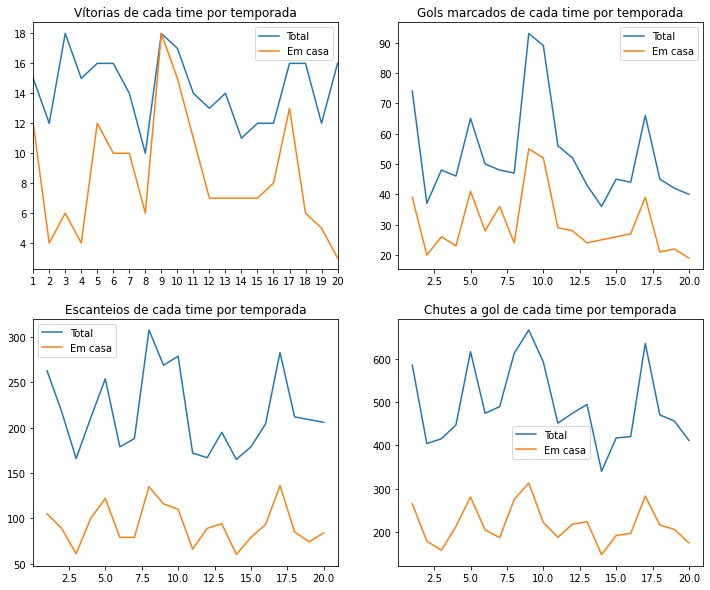

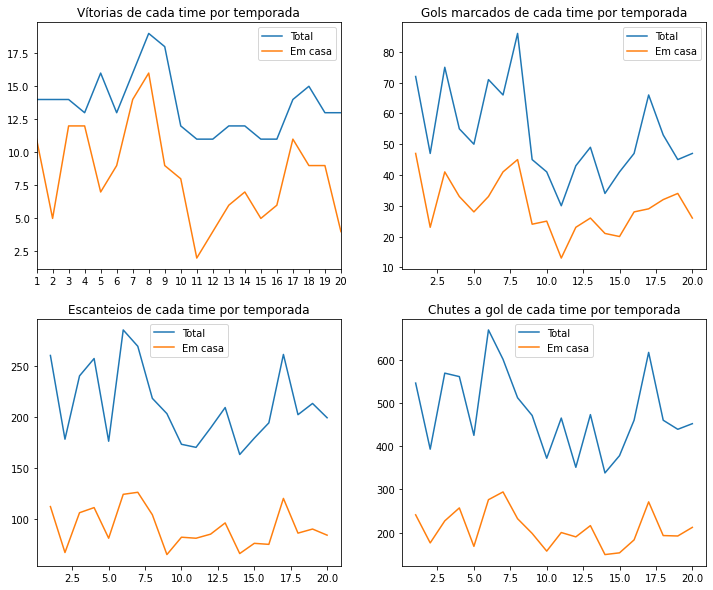

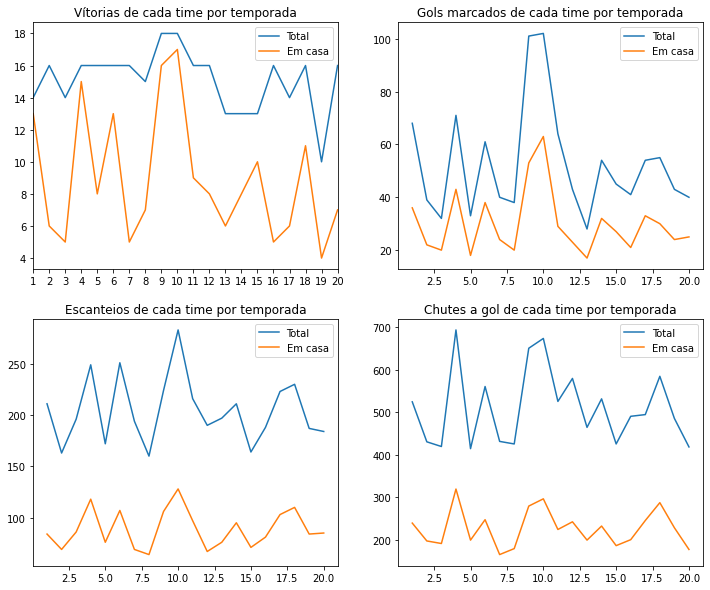

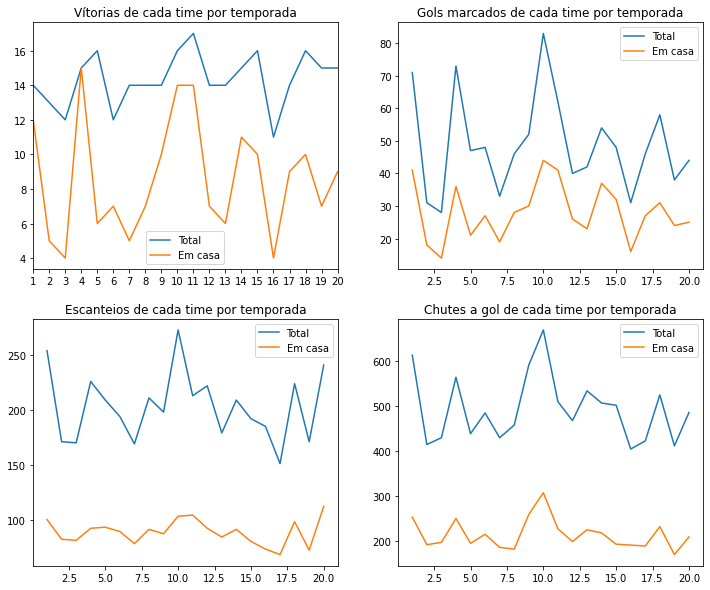

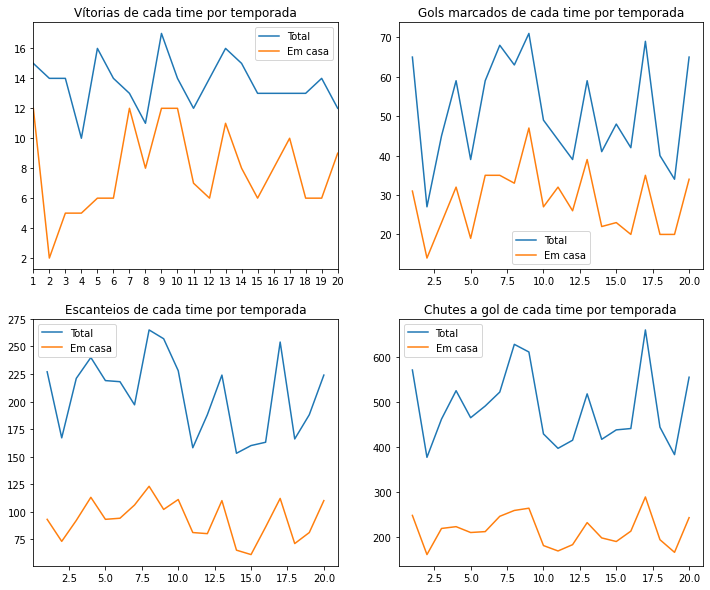

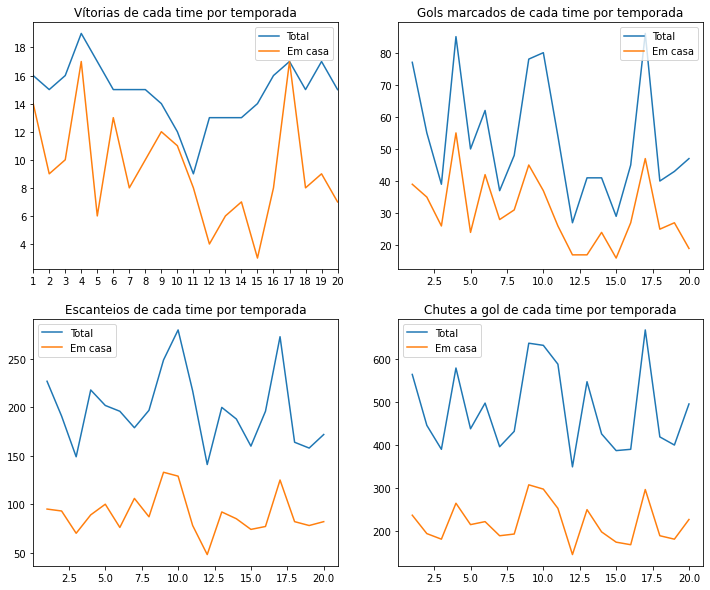

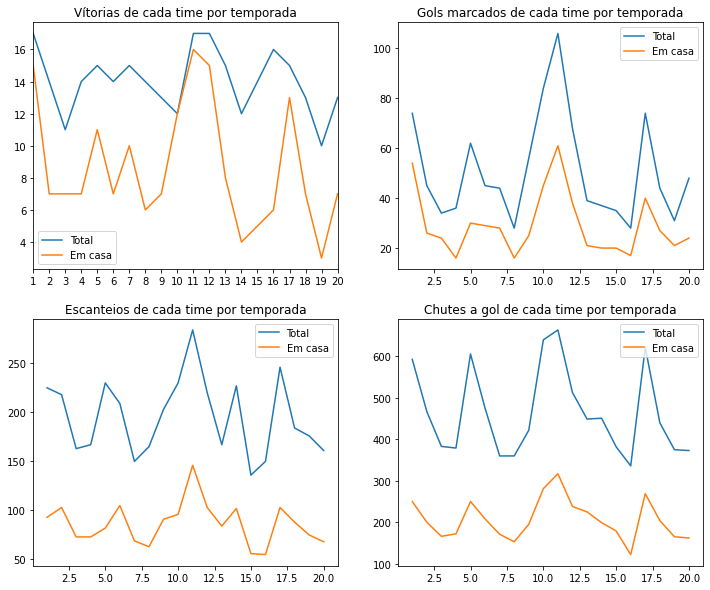

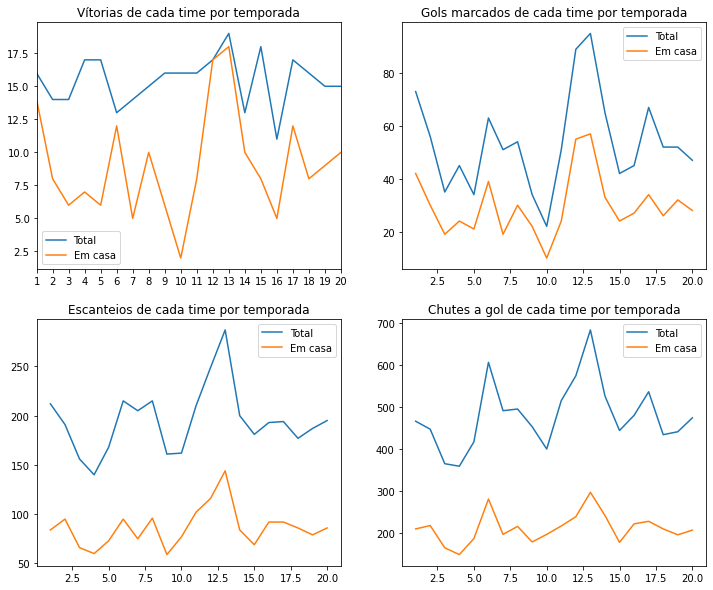

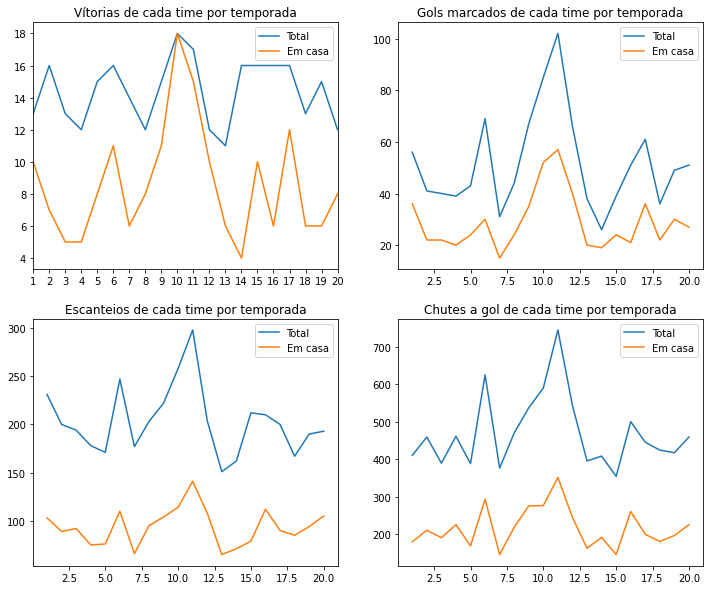

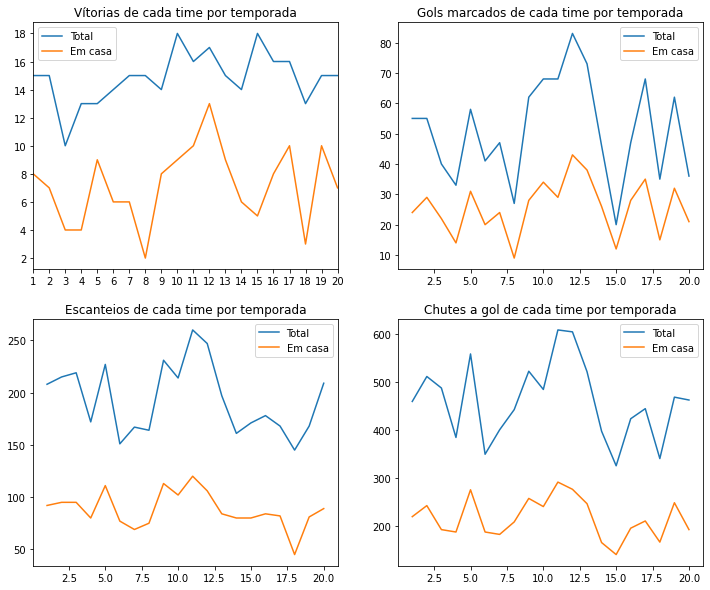

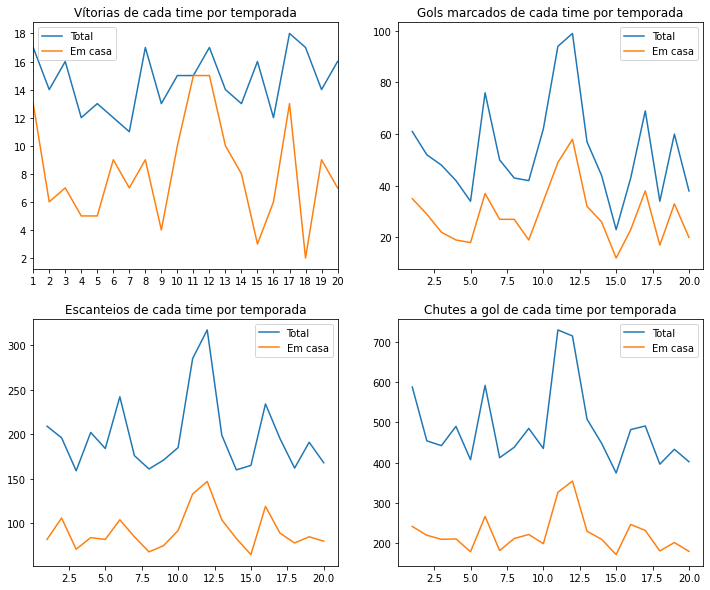

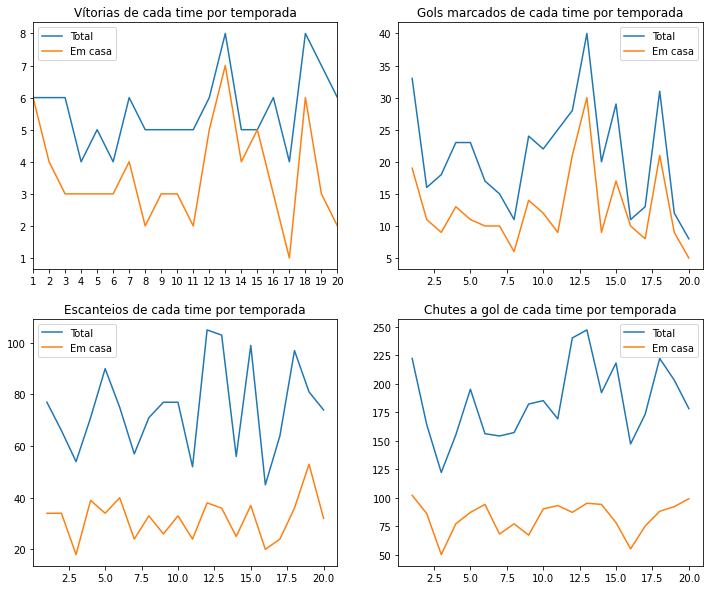

In [24]:
df2_2_plot = df2

for season in df2['temporada'].unique():
    df2_2_plot = df2[(df2['temporada'] == season) & (df2['gols_marcados']!=0)]
    figure, axis = plt.subplots(2, 2,figsize=(12,10))
    axis[0, 0].plot(np.arange(1,len(df2_2_plot)+1,1, dtype=None), df2_2_plot['vitorias'],label="Total")
    axis[0, 0].plot(np.arange(1,len(df2_2_plot)+1,1, dtype=None), df2_2_plot['vitorias_casa'],label="Em casa")
    axis[0, 0].set_title("Vítorias de cada time por temporada")
    axis[0, 0].legend(loc='best')
    axis[0, 0].set_xticks(np.arange(1,len(df2_2_plot)+1))
    axis[0, 0].set_xlim([1, 20])
    
    # For Cosine Function
    axis[0, 1].plot(np.arange(1,len(df2_2_plot)+1,1, dtype=None), df2_2_plot['gols_marcados'],label="Total")
    axis[0, 1].plot(np.arange(1,len(df2_2_plot)+1,1, dtype=None), df2_2_plot['gols_marcados_em_casa'],label="Em casa")
    axis[0, 1].set_title("Gols marcados de cada time por temporada")
    axis[0, 1].legend(loc='best')
    axis[0, 0].set_xticks(np.arange(1,len(df2_2_plot)+1))
    axis[0, 0].set_xlim([1, 20])
    
    # For Tangent Function
    axis[1, 0].plot(np.arange(1,len(df2_2_plot)+1,1, dtype=None), df2_2_plot['escanteios'],label="Total")
    axis[1, 0].plot(np.arange(1,len(df2_2_plot)+1,1, dtype=None), df2_2_plot['escanteios_em_casa'],label="Em casa")
    axis[1, 0].set_title("Escanteios de cada time por temporada")
    axis[1, 0].legend(loc='best')
    axis[0, 0].set_xticks(np.arange(1,len(df2_2_plot)+1))
    axis[0, 0].set_xlim([1, 20])
    
    # For Tanh Function
    axis[1, 1].plot(np.arange(1,len(df2_2_plot)+1,1, dtype=None), df2_2_plot['chutes_a_gol'],label="Total")
    axis[1, 1].plot(np.arange(1,len(df2_2_plot)+1,1, dtype=None), df2_2_plot['chutes_a_gol_em_casa'],label="Em casa")
    axis[1, 1].set_title("Chutes a gol de cada time por temporada")
    axis[1, 1].legend(loc='best')
    axis[0, 0].set_xticks(np.arange(1,len(df2_2_plot)+1))
    axis[0, 0].set_xlim([1, 20])

    # Combine all the operations and display
    plt.show()

## Modelos de machine learning a serem utilizados

### Árvore de decisão

Uma árvore de decisão é um algoritmo de aprendizado de máquina supervisionado que é utilizado para classificação e para regressão. Isto é, pode ser usado para prever categorias discretas (sim ou não, por exemplo) e para prever valores numéricos.

### KNN (K-vizinhos mais próximos)

O algoritmo KNN usa ' semelhança de recursos ' para prever os valores de quaisquer novos pontos de dados. Isso significa que o novo ponto recebe um valor com base em sua semelhança com os pontos do conjunto de treinamento.

### Neural network 

As redes neurais artificiais são um tipo de Machine Learning. A característica mais marcante das redes neurais, é sua estruturação semelhante à rede de neurônios em nosso cérebro.
São sistemas compostos por vários nós que se interconectam em diversas ramificações. As redes neurais aprendem por meio da atualização e ampliação desses laços e interconexões.

O uso de Redes Neurais Artificiais (RNAs), para prever os resultados de uma semana, já foi aplicada especificamente a partidas de futebol da Irã Pro League (IPL) 2013-2014. Os dados obtidos nas partidas anteriores das sete últimas ligas foram usados para fazer melhores previsões para as partidas futuras. Os resultados mostraram que as redes neurais têm uma capacidade notável de prever os resultados de jogos de futebol, como visto em [1].

### Random Forest

Random Forest (floresta aleatória) é uma generalização da operação Árvore de Decisão, em que se utiliza um conjunto de árvores de decisão (aleatórias) a fim de minimizar o sobreajuste (overfitting) de cada modelo individual de árvore gerado para os dados de entrada.

## Preparar dados de treinamento e teste

In [25]:
# Alterando resultado da partiida para valores numéricos
# Onde 0 = derrota do time da casa, 1 = vitória do time da casa e 2 = empate
for index, game_result in enumerate(data['FTR']):
    if game_result == 'H':
        data['FTR'][index] = 1
    elif game_result == 'A':
        data['FTR'][index] = 0
    else: 
        data['FTR'][index] = 2

Para previsão de resultado de jogos futuros, foi implementada uma matriz de dados com janela deslizante de 12 jogos, sendo 11 para alimentar o modelo de treinamento e 12ª o jogo alvo que se deseja obter os parâmetros.

A princípio, pensou-se em identificar apenas o número de escanteios com o auxílio do número de chutes a gol pelo time da casa e time visitante, número de escanteios dos times da casa e visitantes, resultado da partida e número de gols de ambos os times.

In [26]:
#Construindo tabela de treinamento com janela deslizante de 12 partidas
conjunto = 12
n_entradas = 7
# janela de 15 partidas anteriores para a previsão:
col_select = ['FTHG','FTAG','FTR','AC','HS','AS','HC']   
aux_data = data[col_select]
rows = len(aux_data.axes[0])
cols = len(aux_data.axes[1])
dados_janela = pd.DataFrame(np.random.randint(0,1,size=(rows-(conjunto-1), (cols*conjunto)-6)))

for i in range(0,(len(aux_data)-(conjunto-1))):
    for j in range(0,conjunto) :
        if j==(conjunto-1):
            #ultima coluna contem apenas a variavel de resposta desejada
            dados_janela.iloc[i,0+(n_entradas*j)] = aux_data.iloc[i+j,6]
        else: 
            dados_janela.iloc[i,0+(n_entradas*j)] = aux_data.iloc[i+j,0]
            dados_janela.iloc[i,1+(n_entradas*j)] = aux_data.iloc[i+j,1]
            dados_janela.iloc[i,2+(n_entradas*j)] = aux_data.iloc[i+j,2]
            dados_janela.iloc[i,3+(n_entradas*j)] = aux_data.iloc[i+j,3]
            dados_janela.iloc[i,4+(n_entradas*j)] = aux_data.iloc[i+j,4]
            dados_janela.iloc[i,5+(n_entradas*j)] = aux_data.iloc[i+j,5]
            dados_janela.iloc[i,6+(n_entradas*j)] = aux_data.iloc[i+j,6]


Para validação dos modelos, as seguintes métricas serão utilizadas:

Acurácia -> É o número de acertos (positivos) divido pelo número total de exemplos. Ela deve ser usada em dados com a mesma proporção de exemplos para cada classe, e quando as penalidades de acerto e erro para cada classe forem as mesmas.(quanto maior, melhor)

Mean square error -> o Erro Quadrático Médio (EQM) é uma forma de avaliar a diferença entre um estimador e o verdadeiro valor da quantidade estimada. O EQM mede a média do quadrado do erro, com o erro sendo o montante pelo qual o estimador difere da quantidade a ser estimada.(quanto menor, melhor)

Para treinamento foi utilizado 70% da base da dados, e para testes 30%.

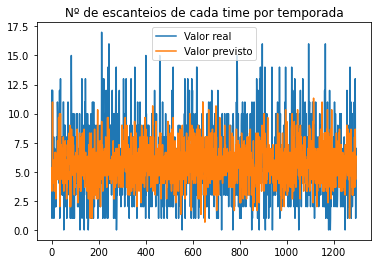

Avaliação (acurácia) do modelo -> Nearest Neighbors...: 0.6255 (train), 0.2232 (test), Erro quadrático médio: 7.204633204633205 , 0:00:00.629000 (tempo calibração)


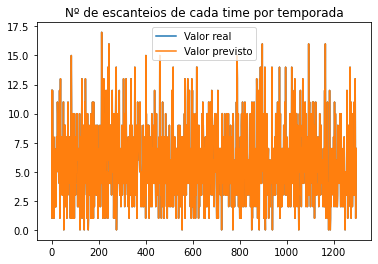

Avaliação (acurácia) do modelo -> Decision Tree.......: 1.0000 (train), 1.0000 (test), Erro quadrático médio: 0.0 , 0:00:00.204996 (tempo calibração)


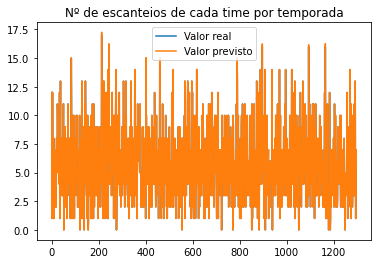

Avaliação (acurácia) do modelo -> Random Forest.......: 1.0000 (train), 1.0000 (test), Erro quadrático médio: 0.0002191505791505798 , 0:00:01.928004 (tempo calibração)


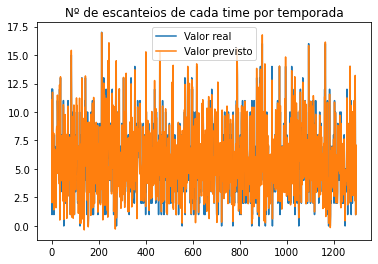

Avaliação (acurácia) do modelo -> Neural Net..........: 0.9996 (train), 0.9704 (test), Erro quadrático médio: 0.27444632795946056 , 0:00:05.427996 (tempo calibração)


In [27]:
#Normalização, divisão e comparativo de acurácia dos diferentes modelos avaliados.
# Foco em apenas 1 parametro -> resultado do jogo 

rows = len(dados_janela.axes[0])
cols = len(dados_janela.axes[1])
X = dados_janela
y = dados_janela.loc[:,(cols-1)]
y = np.array(y)
#
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=None
)
#
names = [
    "Nearest Neighbors",
    # "Linear SVM",
    # "RBF SVM",
    "Decision Tree",
    "Random Forest",
    # "AdaBoost",
    "Neural Net"
]
#
classifiers = [
    KNeighborsRegressor(n_neighbors = 3),
    # SVR(kernel="linear", C=0.025),
    # SVR(gamma=2, C=1),
    DecisionTreeRegressor(max_depth=40),
    RandomForestRegressor(max_depth=42),
    # AdaBoostRegressor(),
    MLPRegressor(max_iter=500)
]

for name, clf in zip(names, classifiers):
    start = datetime.now()
    _ = clf.fit(X_train, y_train)
    accuracy_train, accuracy_test = clf.score(X_train, y_train), clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    # figure, axis = plt.subplt.plots(1, 1,figsize=(12,10))
    plt.plot(np.arange(1,len(y_test)+1,1, dtype=None), y_test,label="Valor real")
    plt.plot(np.arange(1,len(y_pred)+1,1, dtype=None), y_pred,label="Valor previsto")
    plt.title("Nº de escanteios de cada time por temporada")
    plt.legend(loc='best')
    plt.show()
    print(f"Avaliação (acurácia) do modelo -> {name :.<20}: {accuracy_train:.4f} (train), {accuracy_test:.4f} (test), Erro quadrático médio: {mean_squared_error(np.array(y_test), np.array(y_pred))} , {datetime.now()-start} (tempo calibração)")


Os parâmetros trabalhados foram os mais diretos possíveis, sendo o numero de iterações no rede neural, a profundidade das árvores de regressão e random forest, e o número de vizinhanças no KNN.

Os resultados observados de acurácia para os modelos apresentam mostram que o método mais indicado para esta aplicação de regressão sejam os modelos de árvore de decisão e floresta aleatória.

Com aprimoramento de nossas fontes de pesquisas, foi possível observar a existência de modelos que permitem a previsão de multiplos parâmetros. Sendo assim, está última etapa busca prever todas as métricas utilizadas no treinamento anterior. 

In [28]:
#Construindo tabela de treinamento com janela deslizante de 12 partidas
conjunto = 12
n_entradas = 7
# janela de 15 partidas anteriores para a previsão:
col_select = ['FTHG','FTAG','HC','AC','HS','AS','FTR']   
aux_data = data[col_select]
rows = len(aux_data.axes[0])
cols = len(aux_data.axes[1])
dados_janela = pd.DataFrame(np.random.randint(0,1,size=(rows-(conjunto-1), cols*conjunto)))

for i in range(0,(len(aux_data)-(conjunto-1))):
    for j in range(0,conjunto) :

        dados_janela.iloc[i,0+(n_entradas*j)] = aux_data.iloc[i+j,0]
        dados_janela.iloc[i,1+(n_entradas*j)] = aux_data.iloc[i+j,1]
        dados_janela.iloc[i,2+(n_entradas*j)] = aux_data.iloc[i+j,2]
        dados_janela.iloc[i,3+(n_entradas*j)] = aux_data.iloc[i+j,3]
        dados_janela.iloc[i,4+(n_entradas*j)] = aux_data.iloc[i+j,4]
        dados_janela.iloc[i,5+(n_entradas*j)] = aux_data.iloc[i+j,5]
        dados_janela.iloc[i,6+(n_entradas*j)] = aux_data.iloc[i+j,6]
                
            


In [29]:
#Normalização, divisão e comparativo de acurácia dos diferentes modelos avaliados.

col_select = ['FTHG','FTAG','HC','AC','HS','AS','FTR']     
rows = len(dados_janela.axes[0])
cols = len(dados_janela.axes[1])
X = dados_janela.loc[:,0:(cols-8)]
y = dados_janela.loc[:,(cols-7):(cols)]
#

# X = StandardScaler().fit_transform(X)
# y = StandardScaler().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=None
)
#
names = [
    "Nearest Neighbors",
    # "Linear SVM",
    # "RBF SVM",
    "Decision Tree",
    "Random Forest",
    # "AdaBoost",
    "Neural Net"
]
#
classifiers = [
    KNeighborsRegressor(5),
    # SVR(kernel="linear", C=0.025),
    # SVR(gamma=2, C=1),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(max_depth=10),
    # AdaBoostRegressor(),
    MLPRegressor(max_iter=30)
]

for name, clf in zip(names, classifiers):
    start = datetime.now()
    _ = clf.fit(X_train, y_train)
    accuracy_train, accuracy_test = clf.score(X_train, y_train), clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    print(f"Avaliação (acurácia) do modelo -> {name :.<20}: {accuracy_train:.4f} (train), {accuracy_test:.4f} (test), Erro quadrático médio: {mean_squared_error(np.array(y_test), np.array(y_pred))} , {datetime.now()-start} (tempo calibração)")


Avaliação (acurácia) do modelo -> Nearest Neighbors...: 0.2022 (train), -0.2055 (test), Erro quadrático médio: 13.085665747380048 , 0:00:00.519032 (tempo calibração)
Avaliação (acurácia) do modelo -> Decision Tree.......: 0.0754 (train), -0.0017 (test), Erro quadrático médio: 11.405641255042847 , 0:00:00.047965 (tempo calibração)
Avaliação (acurácia) do modelo -> Random Forest.......: 0.2687 (train), 0.0274 (test), Erro quadrático médio: 10.881931563561109 , 0:00:05.198000 (tempo calibração)
Avaliação (acurácia) do modelo -> Neural Net..........: -0.0749 (train), -0.1414 (test), Erro quadrático médio: 11.547704904946759 , 0:00:01.152999 (tempo calibração)


Os resultados observados para a previsão de multiplos parâmetros, apresenta resultados bastante inferiores aos observados na previsão do número de escanteios do próximo jogo para o time da casa, demonstrando a complexidade em se prever, por exemplo qual time irá vencer a partida.

[1]Arabzad, S. M., Tayebi Araghi, M., Sadi-Nezhad, S., Ghofrani, N. (2014). 'Football Match Results Prediction Using Artificial Neural Networks; The Case of Iran Pro League', Journal of Applied Research on Industrial Engineering, 1(3), pp. 159-179.